In [1]:
import numpy as np, os, sys
sys.path.append("..")

import torch
from torch import nn
from torch.nn import functional as F 

from src.utils.synthetic_seqdata import download_data, load_data, sequence_string_to_one_hot
from src.models import DeepBindCNN
from src.trainer import Trainer
from src.utils.datasets import DNASequenceDataset
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib as mpl 
from matplotlib import pyplot as plt 
%matplotlib inline

In [2]:
# get data 
savedir = "./data"
# _=download_data(savedir)
Xs, Ys = load_data(savedir=savedir)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
config = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "architecture": "deepbind",
    "dataset": "synthetic data",
    "epochs": 35,
    "patience": 3,
    }

In [5]:
import wandb
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="deepbind_synthetic_jul27",
    
    # track hyperparameters and run metadata
    config=config
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: harshitandkumar. Use `wandb login --relogin` to force relogin


In [6]:
# set up datasets
datasets = {}
for k in Xs:
    datasets[k] = DNASequenceDataset(sequences=Xs[k], labels=Ys[k], alphabet="ACGT")

# set up dataloaders 
loaders = {}
for k, dataset in datasets.items():
    if k == 'train':
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    else:
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'])
    
# set up the model, lossfn, optimizer, trainer 
model = DeepBindCNN(input_size=4, output_size=1, kernel_size=3)
lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
trainer = Trainer(model, lossfn, optimizer, wandb=wandb)

# fit model
history = trainer.fit(loaders['train'], val_loader=loaders['valid'], nepochs=config['epochs'])

Epoch:   1/35, loss: 54.3894, val_loss: 52.0218
Epoch:   2/35, loss: 53.7163, val_loss: 51.9696
Epoch:   3/35, loss: 53.6341, val_loss: 51.5557
Epoch:   4/35, loss: 53.4218, val_loss: 51.8044
Epoch:   5/35, loss: 53.2638, val_loss: 51.4632
Epoch:   6/35, loss: 53.2288, val_loss: 51.5026
Epoch:   7/35, loss: 53.1762, val_loss: 51.5789
Epoch:   8/35, loss: 53.2221, val_loss: 51.4996
Epoch:   9/35, loss: 53.1625, val_loss: 51.4116
Epoch:  10/35, loss: 53.2059, val_loss: 51.3140
Epoch:  11/35, loss: 53.1173, val_loss: 51.5095
Epoch:  12/35, loss: 53.1684, val_loss: 51.3204
Epoch:  13/35, loss: 53.1586, val_loss: 51.7003
Epoch:  14/35, loss: 53.4175, val_loss: 51.6434
Epoch:  15/35, loss: 53.4095, val_loss: 51.8641
Epoch:  16/35, loss: 53.4679, val_loss: 52.0040
Epoch:  17/35, loss: 53.3912, val_loss: 51.4427
Epoch:  18/35, loss: 53.3881, val_loss: 51.2954
Epoch:  19/35, loss: 53.3253, val_loss: 51.6252
Epoch:  20/35, loss: 53.2460, val_loss: 51.6314
Epoch:  21/35, loss: 53.2608, val_loss: 

In [7]:
history

{'loss': [54.38936590168574,
  53.716275968508086,
  53.6340505216764,
  53.42184992576843,
  53.26380242822377,
  53.2287652394543,
  53.17615534725799,
  53.22214666566892,
  53.16251439046642,
  53.20590267878145,
  53.11725307708461,
  53.168426513671875,
  53.15858930648734,
  53.41750572805535,
  53.409508012745476,
  53.467897193072595,
  53.391163233752664,
  53.388101403571696,
  53.32530004248771,
  53.246024110001514,
  53.260824469126526,
  53.32436022039962,
  53.21762010931425,
  53.31523282560584,
  53.31231356320316,
  53.28234213563405,
  53.361846753995714,
  53.27727159299807,
  53.33787771338197,
  53.394748585409225,
  53.49753155555899,
  53.489753620809616,
  53.471010312642136,
  53.48164646810593,
  53.46595539458811],
 'val_loss': [52.021825336274645,
  51.96957500397213,
  51.55569718376039,
  51.804385079277885,
  51.46323818630643,
  51.50263528975229,
  51.57893625895182,
  51.49958165486654,
  51.411610497368706,
  51.31400480724516,
  51.50954600742885,


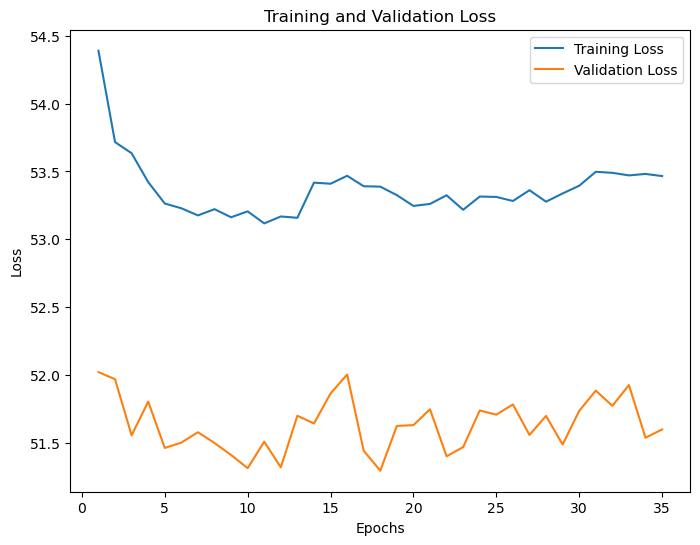

In [8]:
# Calculate AUROC for test predictions
model.eval()
test_scores = []
test_labels = []
with torch.no_grad():
    for inputs, labels in loaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_scores.extend(outputs.cpu().squeeze().tolist())
        test_labels.extend(labels.cpu().tolist())

# Plot training/validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(history['loss'])+1), history['loss'], label='Training Loss')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Test AUROC: 0.7985


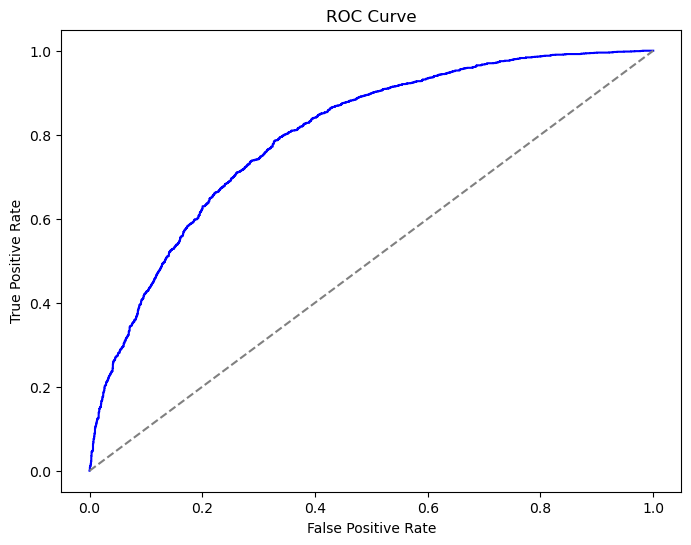

In [9]:
test_auroc = roc_auc_score(test_labels, test_scores)
print(f"Test AUROC: {test_auroc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()